In [1]:

from google.colab import drive
drive.mount('/content/drive/')




Mounted at /content/drive/


In [2]:

!pip install timm torch torchvision


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import os
import timm
from sklearn.model_selection import train_test_split
from collections import Counter


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
!pip install simple_image_download

In [4]:
import os
import shutil
from simple_image_download import simple_image_download
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define dataset path in Google Drive
dataset_path = "/content/drive/MyDrive/dataset2"

# Ensure dataset directory exists
os.makedirs(dataset_path, exist_ok=True)

# List of names (6 celebrities + "unknown" category)
celebrities = [
    "Leonardo DiCaprio", "Brad Pitt", "Tom Cruise",
    "Robert Downey Jr.", "Johnny Depp", "Chris Hemsworth"
]
unknowns = ["random people faces"]

# Initialize downloader
downloader = simple_image_download.simple_image_download()

# Directory where images are downloaded by default
download_dir = "simple_images"

# Download images and move them to Google Drive
for name in celebrities + unknowns:
    print(f"📸 Downloading images for: {name}...")

    # Download 400 images per class
    downloader.download(name, 400)

    # Create category folder in Google Drive
    folder_path = os.path.join(dataset_path, name.replace(" ", "_"))
    os.makedirs(folder_path, exist_ok=True)

    # Ensure download directory exists
    if not os.path.exists(download_dir):
        print(f"❌ Download directory {download_dir} not found!")
        continue

    # Move downloaded images to Google Drive
    downloaded_images = os.listdir(download_dir)
    for image in downloaded_images:
        src = os.path.join(download_dir, image)
        dst = os.path.join(folder_path, image)
        shutil.move(src, dst)  # ✅ FIXED: Proper cross-device move

    print(f"✅ Images saved in {folder_path}")

print("🎉 Dataset is ready in Google Drive!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📸 Downloading images for: Leonardo DiCaprio...
✅ Images saved in /content/drive/MyDrive/dataset2/Leonardo_DiCaprio
📸 Downloading images for: Brad Pitt...
✅ Images saved in /content/drive/MyDrive/dataset2/Brad_Pitt
📸 Downloading images for: Tom Cruise...
✅ Images saved in /content/drive/MyDrive/dataset2/Tom_Cruise
📸 Downloading images for: Robert Downey Jr....
✅ Images saved in /content/drive/MyDrive/dataset2/Robert_Downey_Jr.
📸 Downloading images for: Johnny Depp...
✅ Images saved in /content/drive/MyDrive/dataset2/Johnny_Depp
📸 Downloading images for: Chris Hemsworth...
✅ Images saved in /content/drive/MyDrive/dataset2/Chris_Hemsworth
📸 Downloading images for: random people faces...
✅ Images saved in /content/drive/MyDrive/dataset2/random_people_faces
🎉 Dataset is ready in Google Drive!


In [6]:
from torch.utils.data import Dataset
from PIL import Image, UnidentifiedImageError
import os

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))  # Get class names
        self.image_paths = []
        self.labels = []

        for class_idx, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)

                # Check if image is readable
                if self.is_valid_image(img_path):
                    self.image_paths.append(img_path)
                    self.labels.append(class_idx)
                else:
                    print(f"❌ Removing unreadable image: {img_path}")
                    os.remove(img_path)  # Delete unreadable image

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGBA")  # Convert to RGBA for PNG support
        image = image.convert("RGB")  # Convert RGBA to RGB

        if self.transform:
            image = self.transform(image)

        return image, label

    def is_valid_image(self, img_path):
        """Check if an image is readable."""
        try:
            with Image.open(img_path) as img:
                img.verify()  # Verify image integrity
            return True
        except (UnidentifiedImageError, IOError):
            return False


In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for ViT
    transforms.RandomHorizontalFlip(),  # Data Augmentation
    transforms.RandomRotation(15),  # Random Rotation
    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2)], p=0.5),  # Random Brightness
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize RGB (3 channels)
])


In [16]:
dataset_path = "/content/drive/MyDrive/dataset2"
full_dataset = CustomDataset(dataset_path, transform=transform)

# Get labels for stratified split
labels = [label for _, label in full_dataset]

# Stratified split
train_indices, val_indices = train_test_split(range(len(labels)), test_size=0.2, stratify=labels, random_state=42)

# Subset dataset
train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
val_dataset = torch.utils.data.Subset(full_dataset, val_indices)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Check class distribution
def count_classes(dataset):
    class_counts = Counter()
    for _, label in dataset:
        class_counts[label] += 1
    return class_counts

print("\n📊 Class Distribution:")
print("🔹 Train:", count_classes(train_dataset))
print("🔹 Validation:", count_classes(val_dataset))





❌ Removing unreadable image: /content/drive/MyDrive/dataset2/Brad_Pitt/Brad Pitt_250.jpg
❌ Removing unreadable image: /content/drive/MyDrive/dataset2/Brad_Pitt/Brad Pitt_236.jpg
❌ Removing unreadable image: /content/drive/MyDrive/dataset2/Brad_Pitt/Brad Pitt_11.jpg
❌ Removing unreadable image: /content/drive/MyDrive/dataset2/Brad_Pitt/Brad Pitt_80.jpg
❌ Removing unreadable image: /content/drive/MyDrive/dataset2/Brad_Pitt/Brad Pitt_322.jpg
❌ Removing unreadable image: /content/drive/MyDrive/dataset2/Brad_Pitt/Brad Pitt_375.jpg
❌ Removing unreadable image: /content/drive/MyDrive/dataset2/Brad_Pitt/Brad Pitt_231.jpg
❌ Removing unreadable image: /content/drive/MyDrive/dataset2/Brad_Pitt/Brad Pitt_118.jpg
❌ Removing unreadable image: /content/drive/MyDrive/dataset2/Brad_Pitt/Brad Pitt_102.jpg
❌ Removing unreadable image: /content/drive/MyDrive/dataset2/Brad_Pitt/Brad Pitt_327.jpg
❌ Removing unreadable image: /content/drive/MyDrive/dataset2/Brad_Pitt/Brad Pitt_209.jpg
❌ Removing unreadable i

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ViT model
model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=len(full_dataset.classes))
model.to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Learning rate = 0.0001

print("✅ Model Loaded & Ready for Training!")







/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

✅ Model Loaded & Ready for Training!


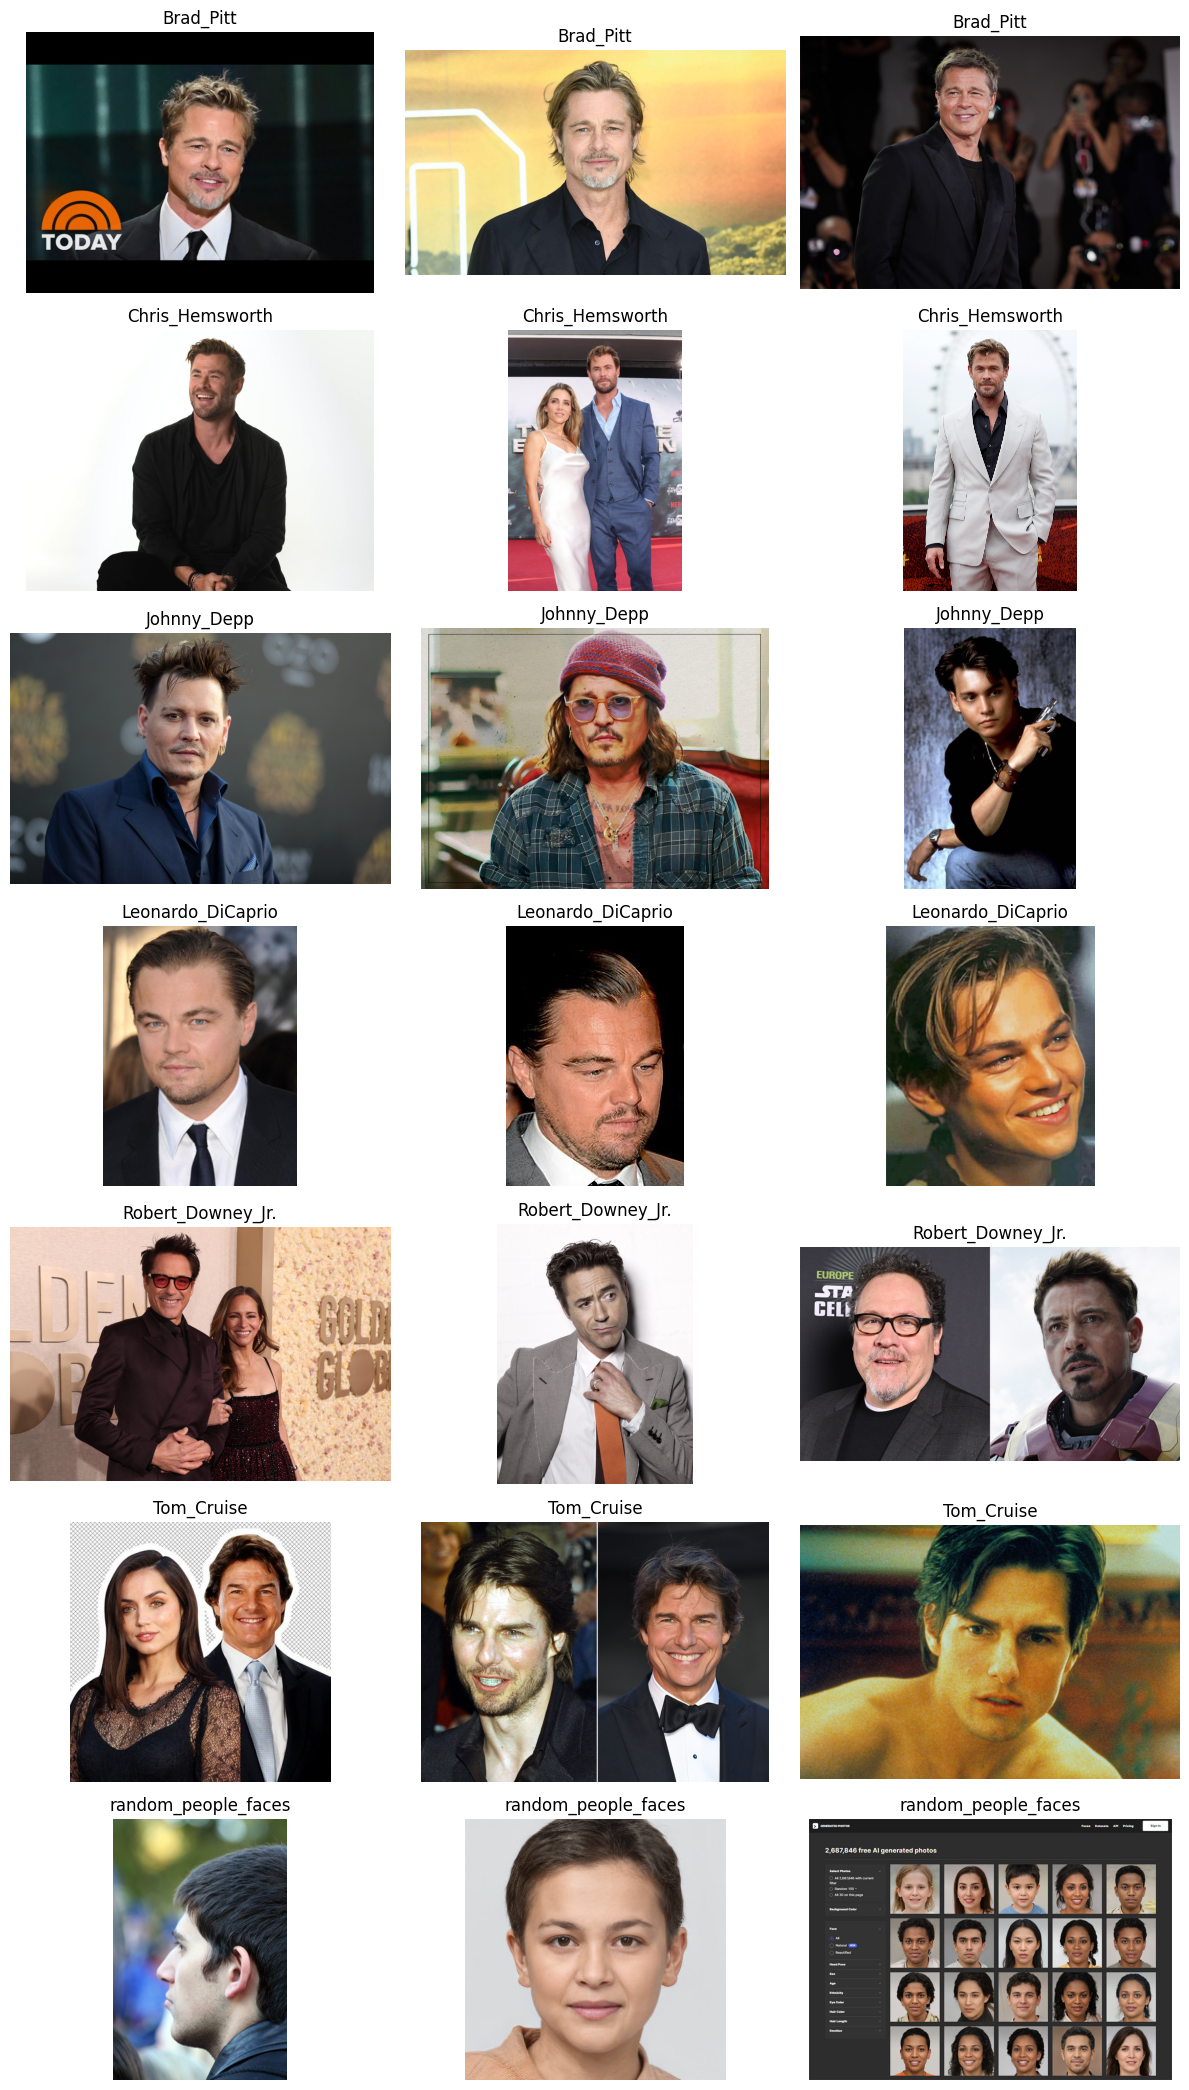

In [11]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# ✅ Define dataset path
dataset_path = "/content/drive/MyDrive/dataset2"

# ✅ Get class names (folders only)
class_names = [cls for cls in sorted(os.listdir(dataset_path)) if os.path.isdir(os.path.join(dataset_path, cls))]

# ✅ Define number of images per class
num_images_per_class = 3

# ✅ Set up figure size
plt.figure(figsize=(12, len(class_names) * 3))

# ✅ Loop through each class and display images
for class_idx, class_name in enumerate(class_names):
    class_folder = os.path.join(dataset_path, class_name)
    image_files = [img for img in os.listdir(class_folder) if img.lower().endswith(('png', 'jpg', 'jpeg'))]

    # ✅ Pick 3 random images (if available)
    selected_images = random.sample(image_files, min(num_images_per_class, len(image_files)))

    for img_idx, image_name in enumerate(selected_images):
        image_path = os.path.join(class_folder, image_name)
        image = Image.open(image_path).convert("RGB")  # Convert to RGB to avoid errors

        # ✅ Create subplot
        plt.subplot(len(class_names), num_images_per_class, class_idx * num_images_per_class + img_idx + 1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"{class_name}")

# ✅ Adjust layout and show images
plt.tight_layout()
plt.show()


In [18]:
num_epochs = 8
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    # Validation Step
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = 100 * correct / total
    val_loss /= len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Save Best Model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "/content/drive/MyDrive/best_vit_model1.pth")
        print("✅ Model Saved!")

print("🎉 Training Complete!")



Epoch [1/8] - Train Loss: 1.1105, Train Acc: 58.74% | Val Loss: 0.1955, Val Acc: 94.05%
✅ Model Saved!
Epoch [2/8] - Train Loss: 0.2277, Train Acc: 92.45% | Val Loss: 0.0968, Val Acc: 96.51%
✅ Model Saved!
Epoch [3/8] - Train Loss: 0.1508, Train Acc: 94.71% | Val Loss: 0.0708, Val Acc: 96.92%
✅ Model Saved!
Epoch [4/8] - Train Loss: 0.0952, Train Acc: 96.61% | Val Loss: 0.1335, Val Acc: 95.48%
Epoch [5/8] - Train Loss: 0.1384, Train Acc: 95.84% | Val Loss: 0.1183, Val Acc: 96.51%
Epoch [6/8] - Train Loss: 0.0659, Train Acc: 97.64% | Val Loss: 0.0236, Val Acc: 99.18%
✅ Model Saved!
Epoch [7/8] - Train Loss: 0.0935, Train Acc: 97.43% | Val Loss: 0.1016, Val Acc: 96.92%
Epoch [8/8] - Train Loss: 0.1142, Train Acc: 96.51% | Val Loss: 0.0592, Val Acc: 98.36%
🎉 Training Complete!


In [4]:
import torch
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Recreate the model with correct number of classes (7 classes)
model = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=7)

# ✅ Load saved weights
model.load_state_dict(torch.load("/content/drive/MyDrive/best_vit_model1.pth", map_location=device))
model.to(device)
model.eval()

print("✅ Model Loaded Successfully & Ready for Testing!")



✅ Model Loaded Successfully & Ready for Testing!


In [9]:
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# ✅ Define the transform (resize, convert to tensor, normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ViT input size
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize for RGB images
])

# ✅ Path to dataset (update this if needed)
dataset_path = "/content/drive/MyDrive/dataset2"

# ✅ Get class names from folder names
class_names = sorted(os.listdir(dataset_path))

def predict_image(image_path):
    """Load, preprocess, and predict a single image."""
    image = Image.open(image_path).convert("RGB")  # Convert to RGB if needed
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = output.max(1)

    predicted_class = class_names[predicted.item()]
    return predicted_class

def test_each_class():
    """Test up to 10 images per class folder and print results."""
    for class_name in class_names:
        class_folder = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_folder):
            continue  # Skip if not a directory

        print(f"\n🔍 Testing up to 10 images for class: {class_name}")
        images = os.listdir(class_folder)[:10]  # Select only the first 10 images

        for image_name in images:
            image_path = os.path.join(class_folder, image_name)

            try:
                predicted_class = predict_image(image_path)
                print(f"➡️ Image: {image_name} | Predicted: {predicted_class}")
            except Exception as e:
                print(f"⚠️ Error processing {image_name}: {e}")

# ✅ Run testing for all classes
test_each_class()



🔍 Testing up to 10 images for class: Brad_Pitt
➡️ Image: Brad Pitt_1.jpg | Predicted: random_people_faces
➡️ Image: Brad Pitt_2.jpg | Predicted: Brad_Pitt
➡️ Image: Brad Pitt_9.jpg | Predicted: Brad_Pitt
➡️ Image: Brad Pitt_6.jpg | Predicted: Brad_Pitt
➡️ Image: Brad Pitt_4.jpg | Predicted: Brad_Pitt
➡️ Image: Brad Pitt_7.jpg | Predicted: Brad_Pitt
➡️ Image: Brad Pitt_10.jpg | Predicted: Brad_Pitt
➡️ Image: Brad Pitt_8.jpg | Predicted: Brad_Pitt
➡️ Image: Brad Pitt_3.jpg | Predicted: Brad_Pitt
➡️ Image: Brad Pitt_5.jpg | Predicted: Brad_Pitt

🔍 Testing up to 10 images for class: Chris_Hemsworth
➡️ Image: Chris Hemsworth_1.jpg | Predicted: random_people_faces
➡️ Image: Chris Hemsworth_2.jpg | Predicted: Chris_Hemsworth
➡️ Image: Chris Hemsworth_4.jpg | Predicted: Chris_Hemsworth
➡️ Image: Chris Hemsworth_3.jpg | Predicted: Chris_Hemsworth
➡️ Image: Chris Hemsworth_6.jpg | Predicted: Chris_Hemsworth
➡️ Image: Chris Hemsworth_7.jpg | Predicted: Chris_Hemsworth
➡️ Image: Chris Hemsworth_1

In [10]:
class_names


['Brad_Pitt',
 'Chris_Hemsworth',
 'Johnny_Depp',
 'Leonardo_DiCaprio',
 'Robert_Downey_Jr.',
 'Tom_Cruise',
 'random_people_faces']

In [9]:
from sklearn.model_selection import train_test_split

# Define dataset directory
dataset_dir = "/content/drive/MyDrive/dataset2"

# Get all images and labels
all_image_paths = []
all_labels = []
class_names = sorted(os.listdir(dataset_dir))

for class_idx, class_name in enumerate(class_names):
    class_path = os.path.join(dataset_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        all_image_paths.append(img_path)
        all_labels.append(class_idx)

# Split into train (80%) and test (20%)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

print(f"Total images: {len(all_image_paths)}")
print(f"Training set: {len(train_paths)} images")
print(f"Testing set: {len(test_paths)} images")

# Check for leakage
overlap = set(train_paths).intersection(set(test_paths))
if len(overlap) > 0:
    print("⚠️ Data leakage detected! Train and test sets have common images.")
else:
    print("✅ No data leakage detected!")


Total images: 2433
Training set: 1946 images
Testing set: 487 images
✅ No data leakage detected!
